In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
# ------------------ TSMixer Model ------------------
class TSMixerBlock(nn.Module):
    def __init__(self, seq_len, hidden_dim, dropout=0.0):
        super().__init__()

        # Token mixing
        self.token_norm = nn.LayerNorm(hidden_dim)
        self.token_mlp = nn.Sequential(
            nn.Linear(seq_len, seq_len * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(seq_len * 2, seq_len),
            nn.Dropout(dropout)
        )

        # Channel mixing
        self.channel_norm = nn.LayerNorm(hidden_dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Token mixing
        y = self.token_norm(x)
        y = y.transpose(1, 2)  # [batch, hidden_dim, seq_len]
        y = self.token_mlp(y)
        y = y.transpose(1, 2)
        x = x + y

        # Channel mixing
        y = self.channel_norm(x)
        y = self.channel_mlp(y)
        x = x + y

        return x


class TSMixer(nn.Module):
    def __init__(self, seq_len, n_features, forecast_horizon, num_blocks=4, hidden_dim=128, dropout=0.1):
        super().__init__()
        self.input_layer = nn.Linear(n_features, hidden_dim)
        self.mixer_blocks = nn.ModuleList([
            TSMixerBlock(seq_len, hidden_dim, dropout)
            for _ in range(num_blocks)
        ])
        self.output_layer = nn.Linear(hidden_dim, forecast_horizon)

    def forward(self, x):
        # x shape: [batch, seq_len, n_features]
        x = self.input_layer(x)
        for block in self.mixer_blocks:
            x = block(x)
        x = x.mean(dim=1)  # Global average pooling over seq_len
        out = self.output_layer(x)
        return out


In [10]:
# ------------------ Dataset Preparation ------------------
def create_sequences(X_data, y_data, seq_len, forecast_horizon):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len - forecast_horizon):
        X_seq.append(X_data.iloc[i:i+seq_len].values)
        y_seq.append(y_data.iloc[i+seq_len:i+seq_len+forecast_horizon].values)
    return np.array(X_seq), np.array(y_seq)

In [11]:
import numpy as np

def desequence(predictions, seq_len, forecast_horizon):
    """
    Reconstruct continuous forecast from overlapping forecasted sequences.
    
    Arguments:
        predictions: numpy array of shape (num_sequences, forecast_horizon)
        seq_len: input sequence length used during training
        forecast_horizon: forecast horizon length
        
    Returns:
        merged_forecast: reconstructed continuous forecast (1D array)
    """
    total_length = len(predictions) + seq_len + forecast_horizon - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start_idx = i + seq_len
        end_idx = start_idx + forecast_horizon
        merged_forecast[start_idx:end_idx] += predictions[i]
        count[start_idx:end_idx] += 1

    # Average overlapping forecasts
    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]

    return merged_forecast


In [31]:
# ------------------ Full Evaluation & Plotting Function ------------------
def evaluate_model_full_plot(model, scaler, X_test, y_test, features, seq_len, forecast_horizon,
                              time_index=None, plot_start=0, plot_end=None):
    # Scale and prepare test sequences
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)
    X_seq, y_seq = create_sequences(X_test_scaled, y_test, seq_len, forecast_horizon)

    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor).numpy()

    # Desequence both predictions and true values
    merged_pred = desequence(preds, seq_len, forecast_horizon)
    merged_true = desequence(y_seq, seq_len, forecast_horizon)

    # Compute metrics
    mse = mean_squared_error(merged_true, merged_pred)
    mae = mean_absolute_error(merged_true, merged_pred)
    rmse = math.sqrt(mse)
    print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Apply slicing range
    if plot_end is None:
        plot_end = len(merged_true)

    # Prepare x-axis
    if time_index is not None:
        time_index = time_index[-len(merged_true):]
        plot_range = time_index[plot_start:plot_end]
    else:
        plot_range = range(plot_start, plot_end)

    # Plotting
    plt.figure(figsize=(16, 6))
    plt.plot(plot_range, merged_true[plot_start:plot_end], label='Actual', color='black')
    plt.plot(plot_range, merged_pred[plot_start:plot_end], label='Forecast', color='red', linestyle='--')
    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title(f"TSMixer Forecast vs Actual [{plot_start}:{plot_end}]")

    plt.legend(loc='upper right')
    plt.grid(True)

    # Add MAE and RMSE on the plot
    textstr = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
    plt.gcf().text(0.02, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.show()


In [32]:
X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

y_test  =org_test_processed[target]
X_test  =org_test_processed[features]

In [29]:
seq_len=24
forecast_horizon=12

In [21]:
model_org = TSMixer(seq_len, len(features), forecast_horizon)

# Load the saved weights
model_org.load_state_dict(torch.load("../Models/weights/tsmixer_org.pth"))


<All keys matched successfully>

In [25]:
model_aug = TSMixer(seq_len, len(features), forecast_horizon)

# Load the saved weights
model_aug.load_state_dict(torch.load("../Models/weights/tsmixer_aug.pth"))

<All keys matched successfully>

In [23]:
import joblib
# Load the saved input scaler
scaler = joblib.load("../Models/weights/scaler_tsmixer_aug.pkl")

/opt/anaconda3/envs/agent_env/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Test MSE: 0.0129, MAE: 0.0861, RMSE: 0.1138


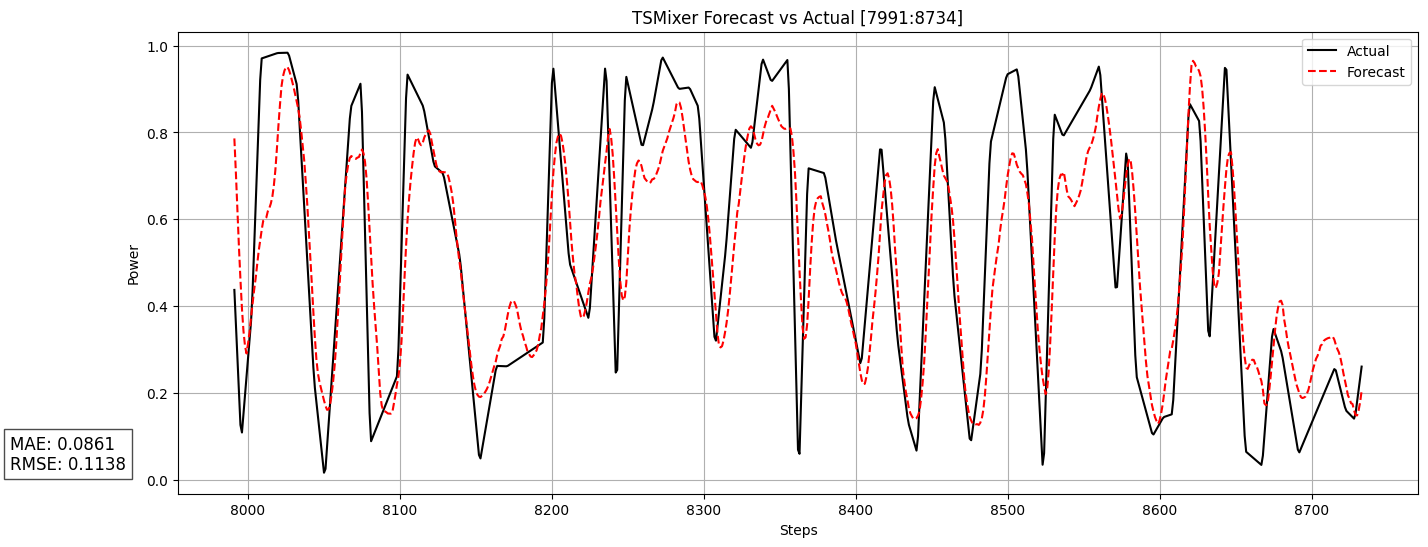

In [33]:
evaluate_model_full_plot(model_org, scaler, X_test, y_test, features, seq_len=24, forecast_horizon=12, plot_start=7991, plot_end=8734)

Test MSE: 0.0141, MAE: 0.0909, RMSE: 0.1187


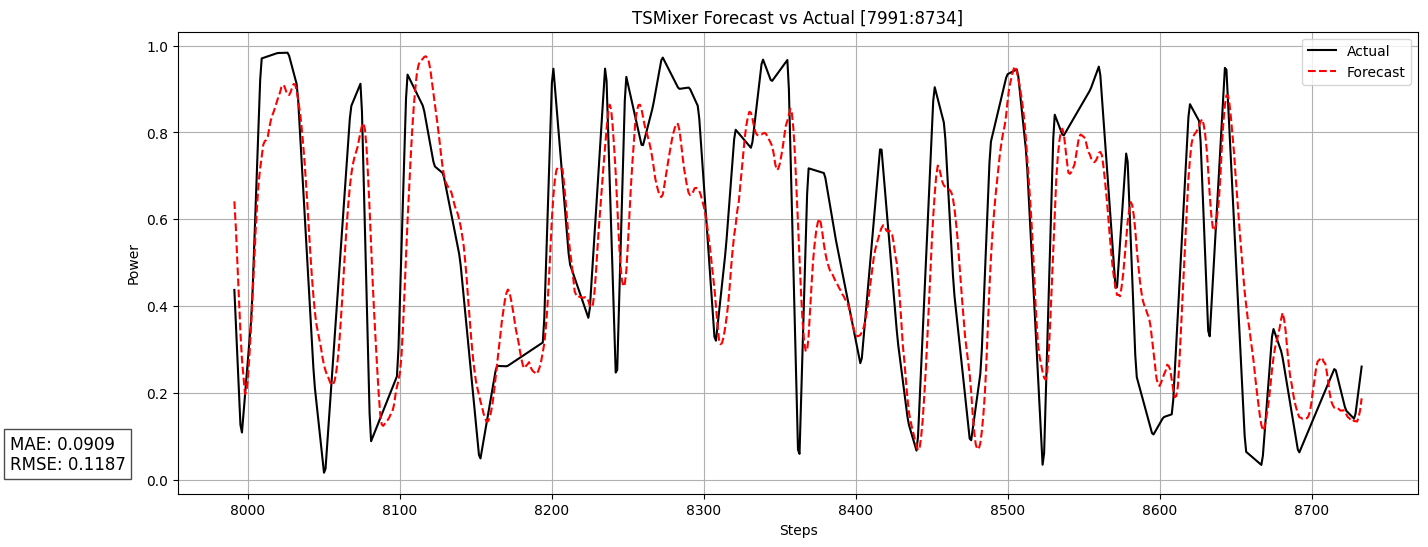

In [26]:
evaluate_model_full_plot(model_aug, scaler, X_test, y_test, features, seq_len=24, forecast_horizon=12, plot_start=7991, plot_end=8734)

In [42]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [46]:
def evaluate_two_tsmixer_models(
    model_org, model_aug,
    scaler_X,
    X_test, y_test,
    y_train_org,
    features,
    seq_len, forecast_horizon,
    time_index=None,
    start_point=0, end_point=None
):
    # Subset test data
    X_test_sub = X_test.iloc[start_point:end_point].reset_index(drop=True)
    y_test_sub = y_test.iloc[start_point:end_point].reset_index(drop=True)

    # Scale X subset
    X_test_scaled = pd.DataFrame(scaler_X.transform(X_test_sub), columns=features)

    # Sequence creation
    X_seq, y_seq = create_sequences(X_test_scaled, y_test_sub, seq_len, forecast_horizon)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    # Original model predictions
    model_org.eval()
    with torch.no_grad():
        preds_org = model_org(X_tensor).numpy()

    # Augmented model predictions
    model_aug.eval()
    with torch.no_grad():
        preds_aug = model_aug(X_tensor).numpy()

    # Desequence all
    merged_pred_org = desequence(preds_org, seq_len, forecast_horizon)
    merged_pred_aug = desequence(preds_aug, seq_len, forecast_horizon)
    merged_true = desequence(y_seq, seq_len, forecast_horizon)

    # Ensure time index and prediction shapes match
    if time_index is not None:
        plot_range = time_index[start_point + seq_len : end_point]
        min_len = min(len(plot_range), len(merged_true))

        plot_range = plot_range[:min_len]
        merged_true = merged_true[:min_len]
        merged_pred_org = merged_pred_org[:min_len]
        merged_pred_aug = merged_pred_aug[:min_len]
    else:
        min_len = min(len(merged_true), len(merged_pred_org), len(merged_pred_aug))
        plot_range = range(min_len)
        merged_true = merged_true[:min_len]
        merged_pred_org = merged_pred_org[:min_len]
        merged_pred_aug = merged_pred_aug[:min_len]

    # Metrics
    mse_org = mean_squared_error(merged_true, merged_pred_org)
    mae_org = mean_absolute_error(merged_true, merged_pred_org)
    rmse_org = math.sqrt(mse_org)

    mse_aug = mean_squared_error(merged_true, merged_pred_aug)
    mae_aug = mean_absolute_error(merged_true, merged_pred_aug)
    rmse_aug = math.sqrt(mse_aug)

    print(f"Original Model - MSE: {mse_org:.4f}, MAE: {mae_org:.4f}, RMSE: {rmse_org:.4f}")
    print(f"Augmented Model - MSE: {mse_aug:.4f}, MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(plot_range, merged_true, label='Actual', color='black')
    plt.plot(plot_range, merged_pred_org, label='Original Forecast', color='red', linestyle='--')
    plt.plot(plot_range, merged_pred_aug, label='Augmented Forecast', color='green', linestyle=':')

    # Highlight error regions
    plt.fill_between(plot_range, merged_true, merged_pred_org,
                     where=(merged_true >= merged_pred_org),
                     interpolate=True, color='pink', alpha=0.3, label='Error (Orig)')
    plt.fill_between(plot_range, merged_pred_org, merged_true,
                     where=(merged_true < merged_pred_org),
                     interpolate=True, color='pink', alpha=0.3)

    plt.fill_between(plot_range, merged_pred_org, merged_pred_aug,
                     where=(merged_pred_aug >= merged_pred_org),
                     interpolate=True, color='lightblue', alpha=0.3, label='Augmented Diff')
    plt.fill_between(plot_range, merged_pred_aug, merged_pred_org,
                     where=(merged_pred_aug < merged_pred_org),
                     interpolate=True, color='lightblue', alpha=0.3)

    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("TSMixer Forecast Comparison: Original vs Augmented")
    plt.legend()
    plt.grid(True)

    # Annotate
    textstr = (
        f'Original Model\nMAE: {mae_org:.4f}\nRMSE: {rmse_org:.4f}\n'
        f'Augmented Model\nMAE: {mae_aug:.4f}\nRMSE: {rmse_aug:.4f}'
    )
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    
    plt.show()

    return {
        "mae_org": mae_org,
        "rmse_org": rmse_org,
        "mae_aug": mae_aug,
        "rmse_aug": rmse_aug
    }

Original Model - MSE: 0.0210, MAE: 0.1127, RMSE: 0.1449
Augmented Model - MSE: 0.0229, MAE: 0.1190, RMSE: 0.1514


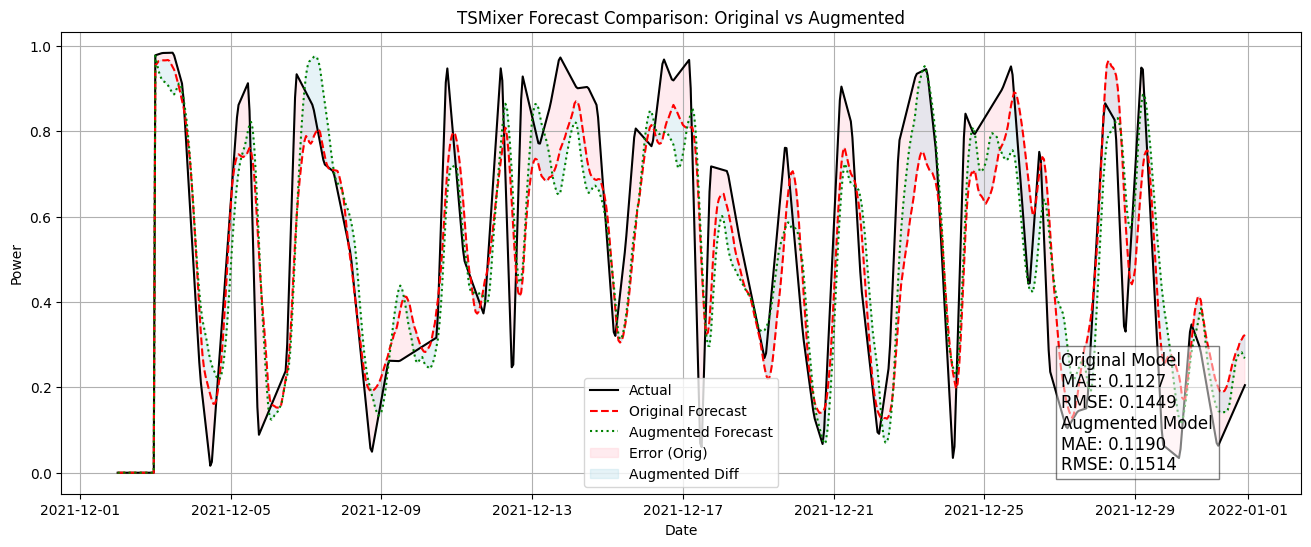

Original Model - MSE: 0.0135, MAE: 0.0901, RMSE: 0.1162
Augmented Model - MSE: 0.0174, MAE: 0.1016, RMSE: 0.1320


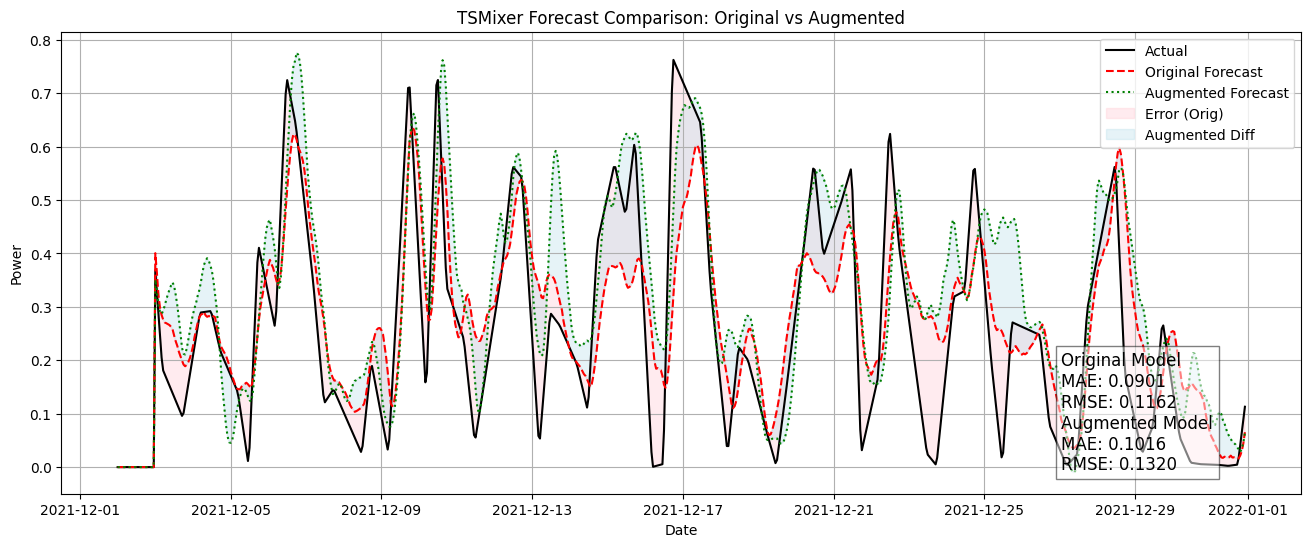

Original Model - MSE: 0.0340, MAE: 0.1530, RMSE: 0.1843
Augmented Model - MSE: 0.0331, MAE: 0.1492, RMSE: 0.1820


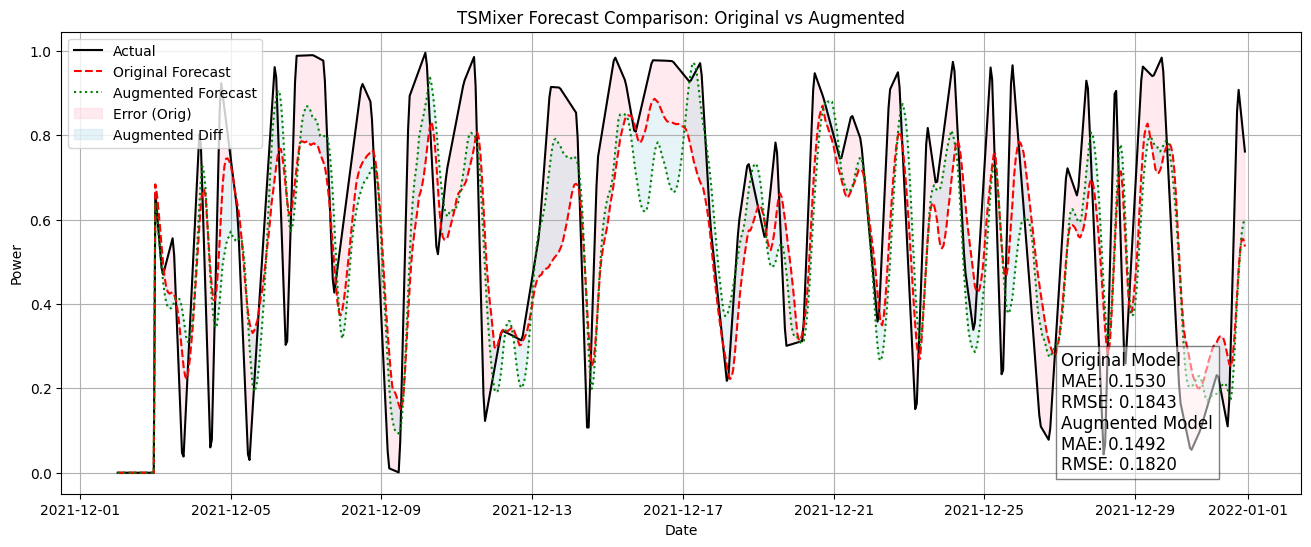

Original Model - MSE: 0.0177, MAE: 0.1077, RMSE: 0.1332
Augmented Model - MSE: 0.0189, MAE: 0.1117, RMSE: 0.1374


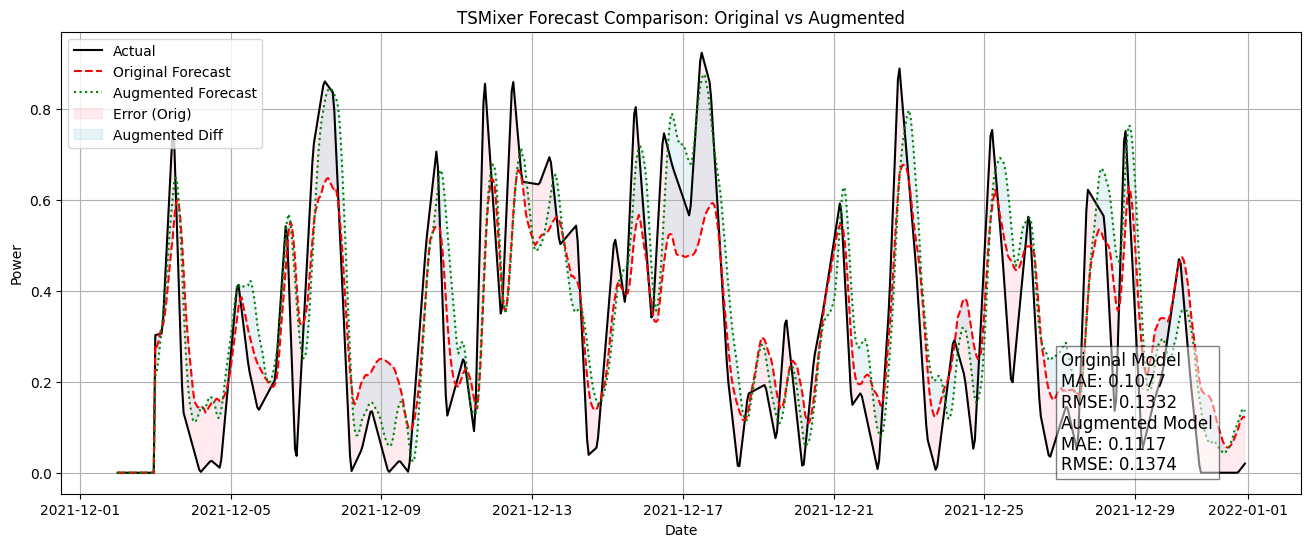

In [47]:
results = evaluate_two_tsmixer_models(
    model_org, model_aug,
    scaler_X=scaler,
    X_test=X_test, y_test=y_test,
    y_train_org=y_train_org,
    features=features,
    seq_len=24, forecast_horizon=12,
    time_index=org_test_processed['Timestamp'], start_point=7991, end_point=8734
)
# Evaluation for interval 1
results_1 = evaluate_two_tsmixer_models(
    model_org, model_aug,
    scaler_X=scaler,
    X_test=X_test,
    y_test=y_test,
    y_train_org=y_train_org,
    features=features,
    seq_len=24,
    forecast_horizon=12,
    time_index=org_test_processed['Timestamp'],
    start_point=16726,
    end_point=17469
)

# Evaluation for interval 2
results_2 = evaluate_two_tsmixer_models(
    model_org, model_aug,
    scaler_X=scaler,
    X_test=X_test,
    y_test=y_test,
    y_train_org=y_train_org,
    features=features,
    seq_len=24,
    forecast_horizon=12,
    time_index=org_test_processed['Timestamp'],
    start_point=25461,
    end_point=26204
)

# Evaluation for interval 3
results_3 = evaluate_two_tsmixer_models(
    model_org, model_aug,
    scaler_X=scaler,
    X_test=X_test,
    y_test=y_test,
    y_train_org=y_train_org,
    features=features,
    seq_len=24,
    forecast_horizon=12,
    time_index=org_test_processed['Timestamp'],
    start_point=34196,
    end_point=34939
)
